In [1]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sys

from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.preprocessing import LabelEncoder

import os 
os.environ['R_HOME'] = 'C:\Program Files\R\R-4.4.0'
from rpy2.robjects import pandas2ri
import anndata2ri

sys.path.insert(0, '../')

import sc_average_overlap as ao

In [2]:
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

C:\Users\chris\AppData\Local\Temp\ipykernel_14332\1038825604.py:2: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
c:\users\chris\appdata\local\programs\python\python39\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [3]:
plt.rcParams["font.family"] = "Arial"
plt.rcParams['svg.fonttype'] = 'none'

## Import thymus data

In [4]:
# now to work with thymus
adata_all = sc.read_10x_mtx(
    'data/wt_thymus_data/WT/',
    var_names='gene_symbols',
    prefix='GSM4721907_WT_',
)
adata_all.var_names_make_unique()

In [5]:
adata_all

AnnData object with n_obs × n_vars = 8931 × 31053
    var: 'gene_ids', 'feature_types'

We first generated log-normalized counts in python.

In [6]:
sc.pp.normalize_total(adata_all, target_sum=1e4)
sc.pp.log1p(adata_all)

Next we read data in R and run Piccolo. These go into the actual anndata we'll work with

In [7]:
%%R -o adata_wt

library(Piccolo)
library(Seurat)
library(SingleCellExperiment)

options(future.globals.maxSize = 8000 * 1024^2)

adata_wt <- CreatePiccoloList(
  MTX = "data/wt_thymus_data/WT/GSM4721907_WT_matrix.mtx.gz", 
  Genes = "data/wt_thymus_data/WT/GSM4721907_WT_features.tsv",
  Barcodes = "data/wt_thymus_data/WT/GSM4721907_WT_barcodes.tsv"
)

adata_wt <- FilterCells(
  PiccoloList = adata_wt,
  MinFeaturesPerCell = 100,
  MT.Perc = 12, # default value is 12
  RP.Perc = 80,
  TotalCountsMADLow = NULL,
  TotalCountsMADHigh = NULL
)

adata_wt <- PrepareCountsForSeurat(PiccoloList = adata_wt)
adata_wt <- CreateSeuratObject(counts = adata_wt$Counts)

adata_wt <- SCTransform(object = adata_wt, vst.flavor = "v2")
adata_wt <- SelectFeaturesForSeurat(Obj = adata_wt, NoOfHVG = 3000) 
adata_wt <- NormalizeForSeurat(Obj = adata_wt)

adata_wt <- as.SingleCellExperiment(adata_wt)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

Loading required package: SeuratObject
Loading required package: sp

Attaching package: 'SeuratObject'

The following objects are masked from 'package:base':

    intersect, t

Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loading required package: matrixStats

Attaching package: 'MatrixGenerics'

The following objects are masked from 'package:matrixStats':

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCu

In [8]:
adata_wt

AnnData object with n_obs × n_vars = 7969 × 2996
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'ident'
    layers: 'logcounts', 'scaledata'

Piccolo output has now been converted to an AnnData object. We will combine the Piccolo residuals with the log-norm counts we determined earlier

In [9]:
adata_all = adata_all[adata_wt.obs.index].copy() # some cells got filtered out in Piccolo. 
adata_all

AnnData object with n_obs × n_vars = 7969 × 31053
    var: 'gene_ids', 'feature_types'
    uns: 'log1p'

In [10]:
adata_wt.raw = adata_all # replace raw attribute of adata_wt with 'raw' lognormed counts
adata_wt.X = adata_wt.layers['scaledata']

We have the Piccolo residuals in 'scaledata', now we can run the usual PCA + downstream analysis using them

In [11]:
n_pcs = 51
sc.pp.pca(adata_wt, svd_solver="arpack", layer='scaledata', n_comps=100)
sc.pp.neighbors(adata_wt, n_neighbors=10, n_pcs=n_pcs, use_rep='X_pca', )
sc.tl.umap(adata_wt)

C:\Users\chris\AppData\Local\Temp\ipykernel_14332\1796513828.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_wt, resolution=1)


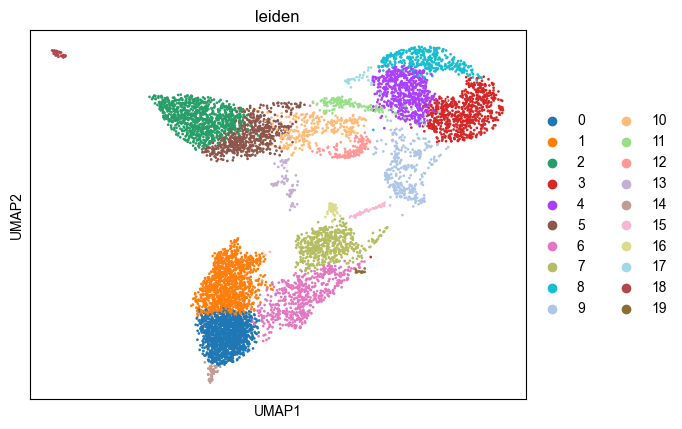

In [12]:
sc.tl.leiden(adata_wt, resolution=1)
sc.pl.umap(adata_wt, color=['leiden'],  )

In [13]:
# Reorder leiden labels to better align with T cell trajectory
leiden_relabel = {
    '13': '0',
    '10': '1',
    '12': '2',
    '5': '3',
    '2': '4',
    '11': '5',
    '4': '6',
    '8': '7',
    '17': '8',
    '3': '9',
    '9': '10',
    '15': '11',
    '1': '12',
    '0': '13',
    '14': '14',
    '6': '15',
    '7': '16',
    '16': '17',
    '19': '18',
    '18': '19'
}


adata_wt.obs['leiden_reordered'] = adata_wt.obs['leiden']
adata_wt.obs['leiden_reordered'] = (
    adata_wt.obs['leiden_reordered']
    .map(lambda x: leiden_relabel.get(x, x)) # get() with 2 arguments returns the key itself if it doesn't exist in dict
    .astype('category')
)

adata_wt.obs['leiden_reordered'] = pd.Categorical(
    values=adata_wt.obs.leiden_reordered, categories=adata_wt.obs['leiden'].cat.categories.to_list(), ordered=True
)

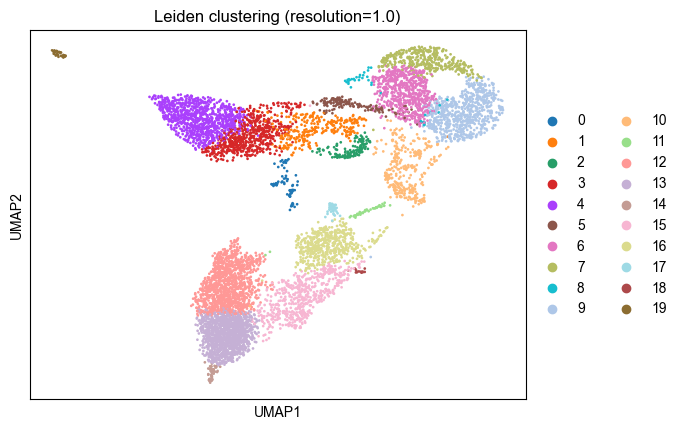

In [14]:
sc.pl.umap(adata_wt, color=['leiden_reordered'], title='Leiden clustering (resolution=1.0)', )

We found in our analysis with ImmGen and [MyGeneSet](https://rstats.immgen.org/MyGeneSet_New/index.html) that some cells mapped closely to granulocytes (cluster 19) or B cells. We show high expression of B cell marker genes below.

We will filter these cells out as we are only interested in cells belonging to T cell lineage.

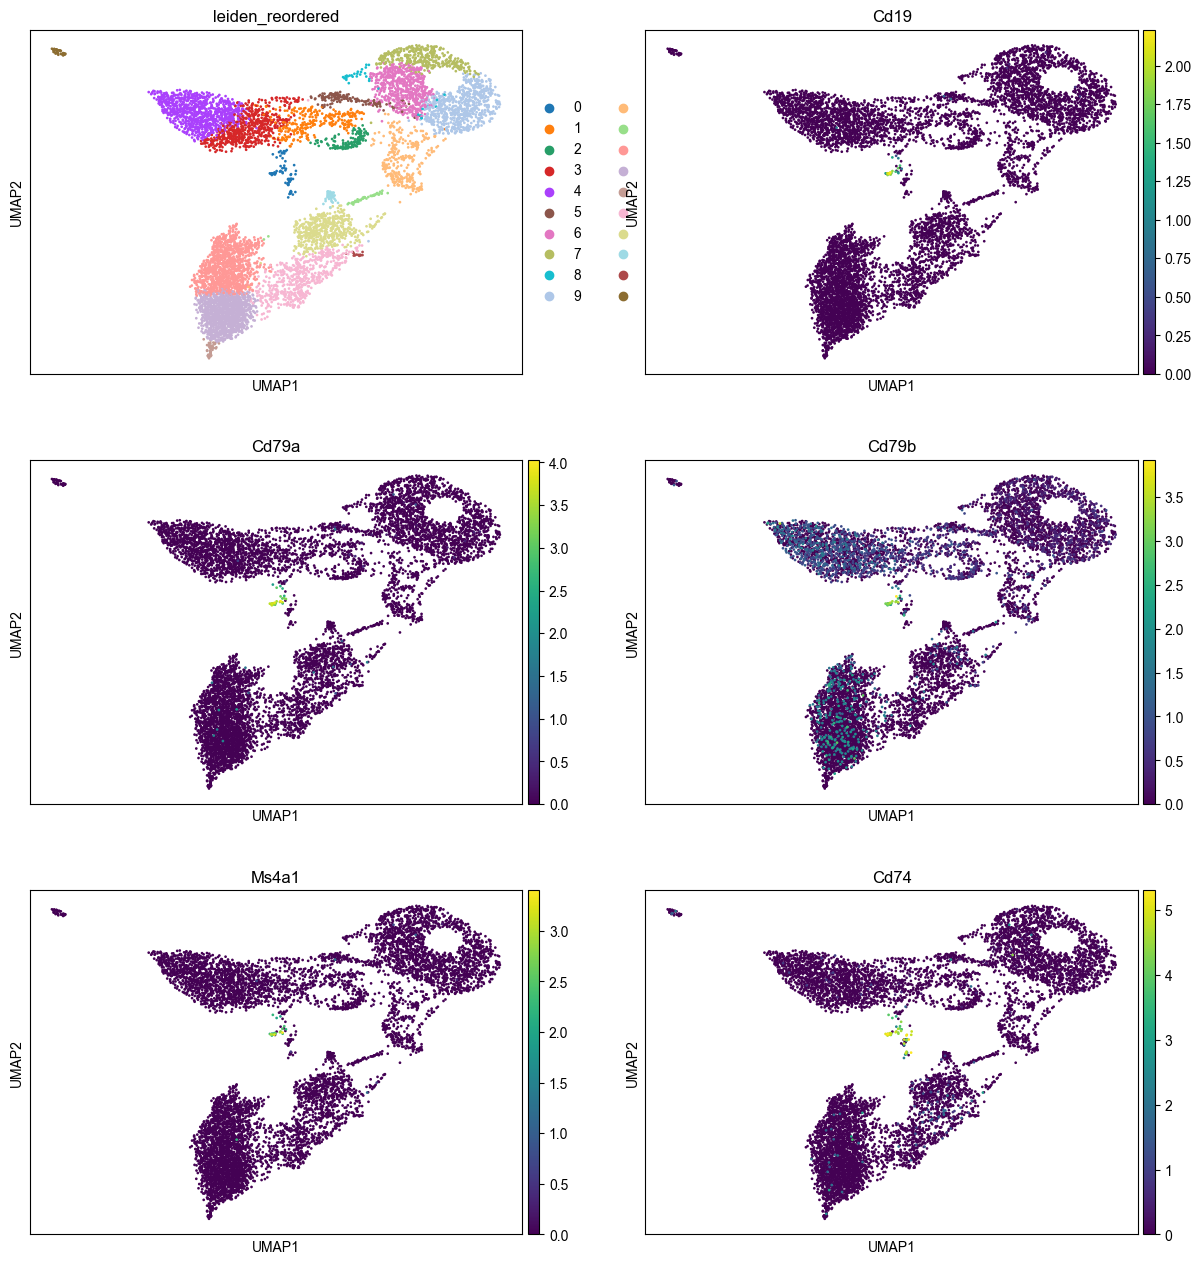

In [15]:
sc.pl.umap(adata_wt, 
           color=['leiden_reordered',  'Cd19', 'Cd79a', 'Cd79b', 'Ms4a1', 'Cd74'], ncols=2, 
           )

In [16]:
# create a B-cell 'signature'
b_cell_markers = ['Cd19', 'Cd79a', 'Cd79b', 'Ms4a1', 'Cd74', ]
sc.tl.score_genes(adata_wt, b_cell_markers, score_name='B_cell_score')

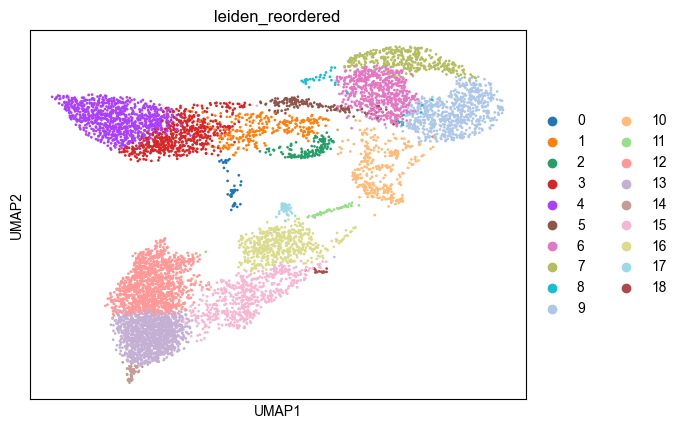

In [17]:
# Actually filter out cells
adata_wt = adata_wt[adata_wt.obs['B_cell_score'] < 1.0] # Obvious b cells are out
adata_wt = adata_wt[adata_wt.obs['leiden_reordered'] != '19'] # Obvious granulocytes are out
sc.pl.umap(adata_wt, color='leiden_reordered', )

### Construct the average overlap tree

First we run differential expression analysis, using the Wilcoxon rank-sum test. Then, we combine all clusters' top 25 DE genes into a single set to be ranked by each cluster. These rankings are what AO-based hierarchical clustering will use.

In [18]:
cat = 'leiden_reordered'
sc.tl.rank_genes_groups(adata_wt, groupby=cat, method='wilcoxon', tie_correct=True, use_raw=True)

c:\users\chris\appdata\local\programs\python\python39\lib\site-packages\scanpy\tools\_rank_genes_groups.py:640: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
c:\users\chris\appdata\local\programs\python\python39\lib\site-packages\scanpy\tools\_rank_genes_groups.py:352: RuntimeWarning: invalid value encountered in divide
  scores[group_index, :] = (
c:\users\chris\appdata\local\programs\python\python39\lib\site-packages\scanpy\tools\_rank_genes_groups.py:352: RuntimeWarning: invalid value encountered in divide
  scores[group_index, :] = (
c:\users\chris\appdata\local\programs\python\python39\lib\site-packages\scanpy\tools\_rank_genes_groups.py:352: RuntimeWarning: invalid value encountered in divide
  scores[group_index, :] = (
c:\users\chris\appdata\local\programs\python\python39\lib\site-packages\scanpy\tools\_rank_genes_groups.py:352: RuntimeWarning: invalid value encountered in divide
  scores[group_

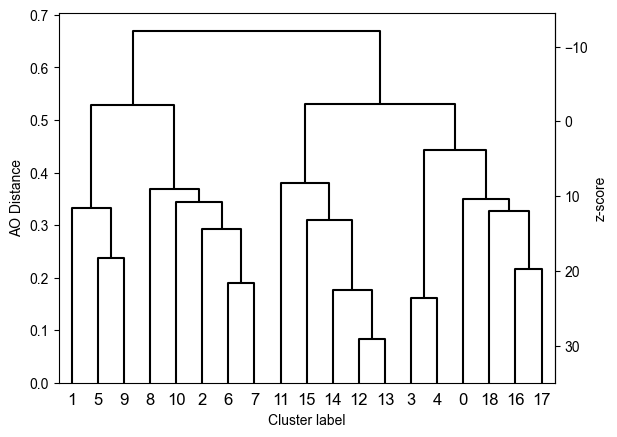

In [19]:
marker_gene_set = ao.get_all_cluster_markers(adata_wt, 'leiden_reordered', n_genes=25)
ao.make_ao_dendrogram(adata_wt, groupby=cat, genes_to_filter=marker_gene_set)

_, ax = ao.plot_ao_dendrogram(adata_wt, key=cat)
plt.show()

We then merge clusters, and assign annotations based on expression of markers in ImmGen bulk sorted populations of thymoctyes.

In [20]:
merge_1_dict = {
    '13': '12',
    '4': '3',
    '14': '12',
    '7': '6',
}

adata_wt.obs['leiden_2'] = adata_wt.obs['leiden_reordered']
adata_wt.obs['leiden_2'] = (
    adata_wt.obs['leiden_2']
    .map(lambda x: merge_1_dict.get(x, x)) # get() with 2 arguments returns the key itself if it doesn't exist in dict
    .astype('category')
)

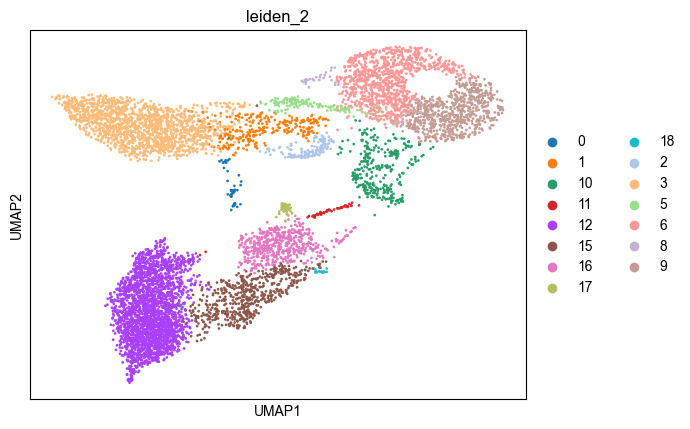

In [21]:
sc.pl.umap(adata_wt, color=['leiden_2'])

In [22]:
annotation_dict = {
    '3': 'DN3a',
    '1': 'DN2a',
    '2': 'DN2b',
    '0': 'MPP/DN1',
    '5': 'DN3b',
    '6': 'DN4/ISP (G2/M phase)',
    '9': 'DN4/ISP (S phase)',
    '10': 'ISP',
    '11': 'ISP to DP',
    '12': 'DP',
    '15': 'CD4 T',
    '16': 'CD8 T',
    '17': 'NK cell',
    '18': 'gd T',
    '8': 'DN4/ISP (G2/M phase) - Apoptotic'
}

adata_wt.obs['final_annotation'] = adata_wt.obs['leiden_2']
adata_wt.obs['final_annotation'] = (
    adata_wt.obs['final_annotation']
    .map(lambda x: annotation_dict.get(x, x)) # get() with 2 arguments returns the key itself if it doesn't exist in dict
    .astype('category')
)

ordered_annotations = ['MPP/DN1', 'DN2a', 'DN2b', 'DN3a', 'DN3b', 'DN4/ISP (S phase)', 'DN4/ISP (G2/M phase)', 
                       'DN4/ISP (G2/M phase) - Apoptotic', 'ISP', 'ISP to DP', 'DP', 'CD4 T', 'CD8 T', 'NK cell', 'gd T']

adata_wt.obs['final_annotation'] = pd.Categorical(
    values=adata_wt.obs.final_annotation, categories=ordered_annotations, ordered=True
)

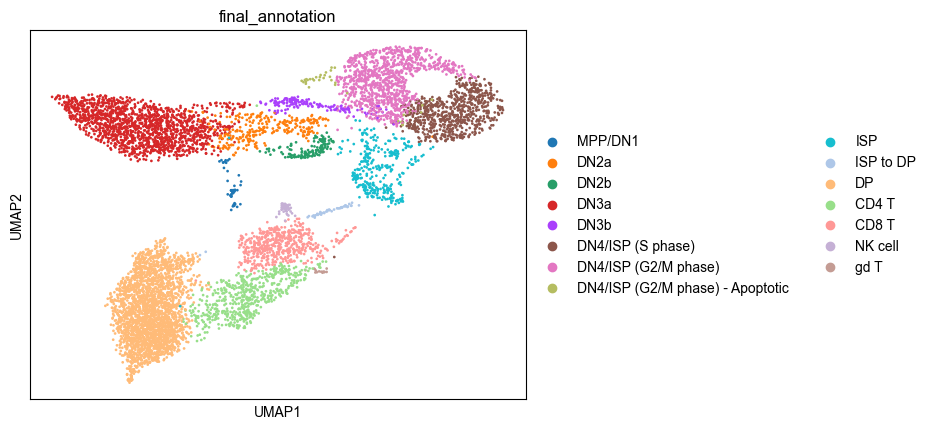

In [23]:
sc.pl.umap(adata_wt, color=['final_annotation'])

## Cell cycle signature

In [24]:
cell_cycle_genes = [x.strip().capitalize() for x in open('data/cell_cycle_genes.txt')]

s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

sc.tl.score_genes_cell_cycle(adata_wt, s_genes=s_genes, g2m_genes=g2m_genes)

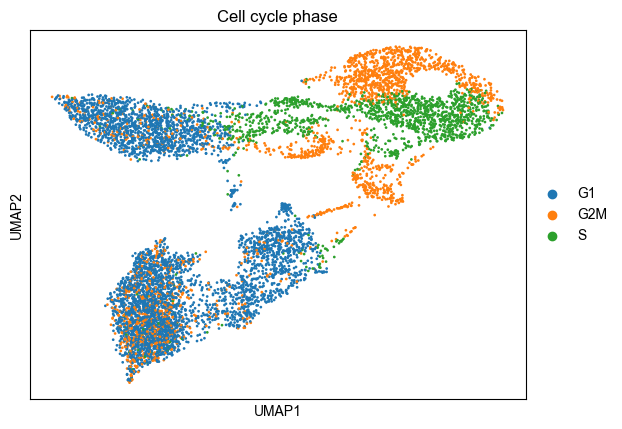

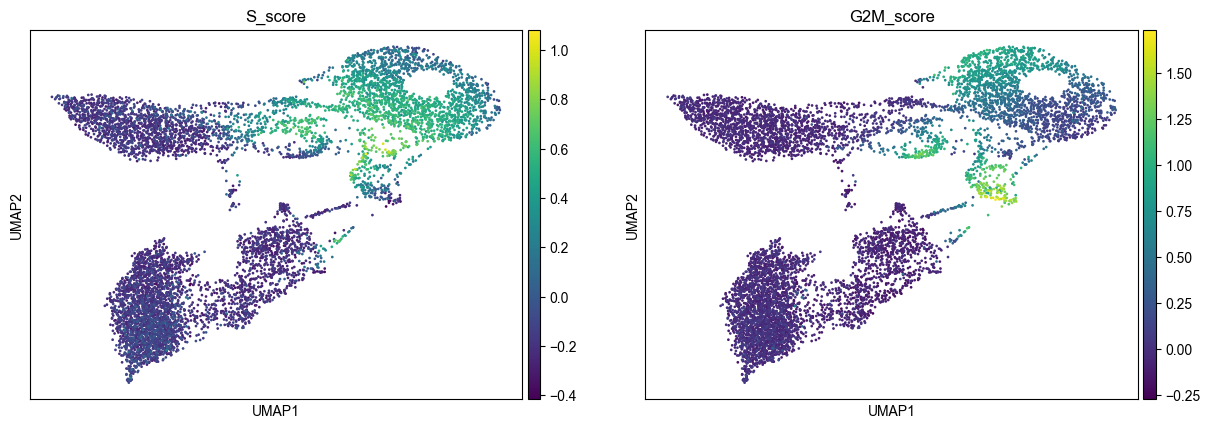

In [25]:
sc.pl.umap(adata_wt, color=['phase', ], title='Cell cycle phase')
sc.pl.umap(adata_wt, color=['S_score', 'G2M_score', ])